In [1]:
import sys

import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation

# Introduction to OpenAI gym

In [2]:
import gym

In [4]:
gym.envs.registry

{'ALE/Adventure-v5': EnvSpec(id='ALE/Adventure-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'rgb', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure', version=5),
 'ALE/Adventure-ram-v5': EnvSpec(id='ALE/Adventure-ram-v5', entry_point='ale_py.env.gym:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'game': 'adventure', 'obs_type': 'ram', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Adventure-ram', version=5),
 'ALE/AirRaid-v5': EnvSpec(id='ALE/AirRaid-v5', 

In [16]:
env=gym.make('CartPole-v1',render_mode='rgb_array')

In [18]:
#env.seed(42)
obs=env.reset()

In [19]:
obs

(array([-0.03196066,  0.01972779, -0.04214048, -0.01103479], dtype=float32),
 {})

In [9]:
try:
    import pyvirtualdisplay
    display= pyvirtualdisplay.Display(visible=0, size=(1400,900)).start()
except ImportError:
    pass

In [21]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [22]:
img= env.render()
img.shape

(400, 600, 3)

In [12]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img=env.render()
    plt.imshow(img)
    plt.axis('off')
    return img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

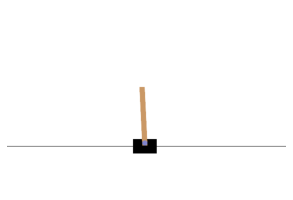

In [24]:
plot_environment(env)

In [25]:
env.action_space

Discrete(2)

In [35]:
action=1
obs, reward, done, _, info=env.step(action)
obs

array([ 0.00915857,  0.9988353 , -0.10457171, -1.5578728 ], dtype=float32)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

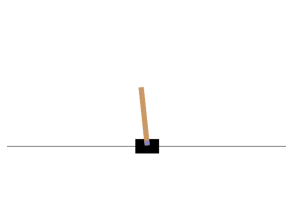

In [36]:
plot_environment(env)

In [37]:
reward

1.0

In [38]:
done

False

In [39]:
info

{}

In [40]:
if done:
    obs=env.reset()

# A simple hard-coded policy